In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

To explore time series models, we will continue with the Rossmann sales data. This dataset has sales data for sales at every Rossmann store for a 3-year period, as well indicators of holidays and basic store information.

In the last class, we saw that we would plot the sales data at a particular store to identify how the sales changed over time. Additionally, we computed autocorrelation for the data at varying lag periods. This helps us identify if previous timepoints are predictive of future data and which time points are most important - the previous day? week? month?

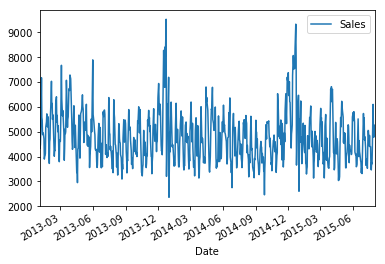

In [4]:
import pandas as pd

# Load the data and set the DateTime index
data = pd.read_csv('../../DS-SF-32/lessons/lesson-17/rossmann.csv', skipinitialspace=True)

data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Filter to Store 1
store1_data = data[data.Store == 1]

# Filter to open days
store1_open_data = store1_data[store1_data.Open==1]

# Plot the sales over time
store1_open_data[['Sales']].plot()

In [5]:
store1_open_data.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1
2015-07-30,1,4,5020,546,1,1,0,1
2015-07-29,1,3,4782,523,1,1,0,1
2015-07-28,1,2,5011,560,1,1,0,1
2015-07-27,1,1,6102,612,1,1,0,1


**Check** Compute the autocorrelation of Sales in Store 1 for lag 1 and 2. Will we be able to use a predictive model - particularly an autoregressive one?

In [6]:
store1_data.Sales.autocorr(lag=1) # -0.12

-0.12732514339140219

In [9]:
store1_open_data.Sales.autocorr(lag=1) # 0.68

0.68269082422794292

In [10]:
store1_data.Sales.autocorr(lag=2) # -0.03

-0.034787155707946972

In [12]:
store1_open_data.Sales.autocorr(lag=2) # 0.48

0.48121726614607269

Pandas and statsmodels both provide convenience plots for autocorrelations.

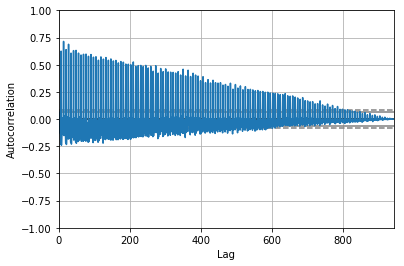

In [14]:
from pandas.tools.plotting import autocorrelation_plot

autocorrelation_plot(store1_data.Sales)

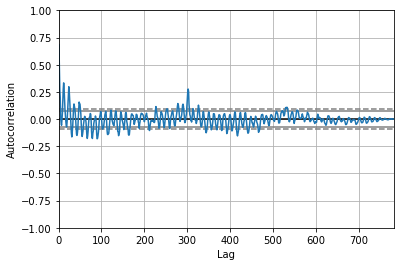

In [18]:
autocorrelation_plot(store1_open_data.Sales)
# there's an extra spike around 312 at the 'open year' mark

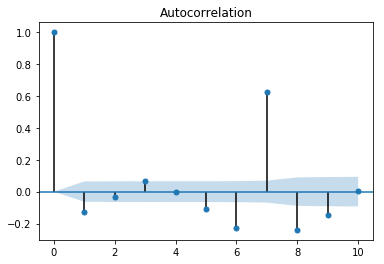

In [16]:
from statsmodels.graphics.tsaplots import plot_acf
# y axis is auto-correlation
# x axis is lag

plot_acf(store1_data.Sales, lags=10)
plt.show()

**Check**: What caused the spike at 7?

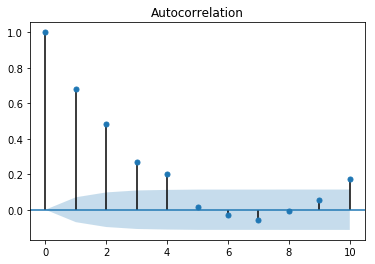

In [17]:
plot_acf(store1_open_data.Sales, lags=10)
plt.show()

In [21]:
from statsmodels.tsa.seasonal import seasonal_decompose

daily = store1_open_data[['Sales']]

weekly_opendays = store1_data['Sales'].resample("W").sum()

X = weekly_opendays


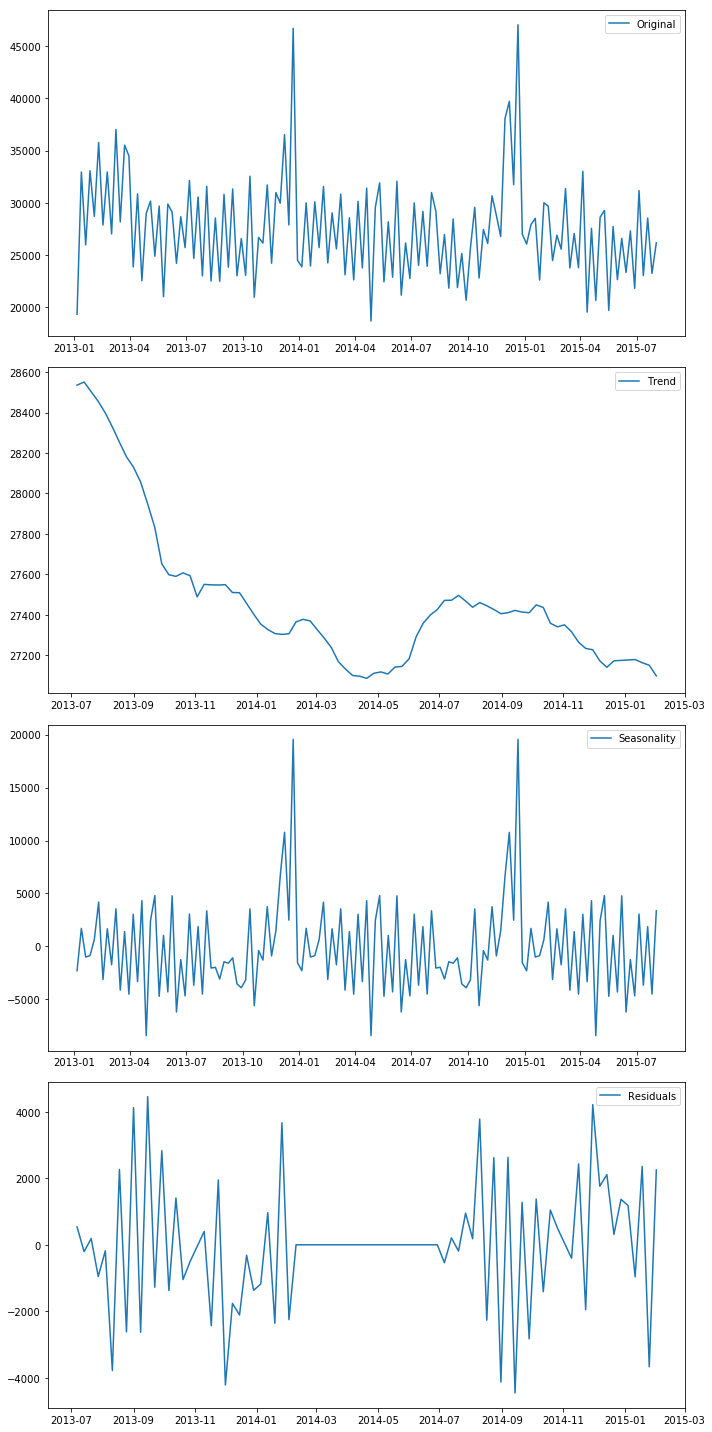

In [23]:
#decomposition = seasonal_decompose(store1_data['Sales'])

decomposition = seasonal_decompose(X)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid   # what's not explained by trend and seasonality?

fig = plt.figure(figsize=(10, 20)) 


plt.subplot(411)
plt.plot(X, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

# ARMA Model

Recall that `ARMA(p, q)` models are a sum of an `AR(p)` and a `MA(q)` model. So if we want just an `AR(p)` model we use and `ARMA(p, 0)` model. 

In [51]:
X.head(3)

Date
2013-01-06    19340
2013-01-13    32952
2013-01-20    25978
Freq: W-SUN, Name: Sales, dtype: int64

In [24]:
from statsmodels.tsa.arima_model import ARMA

# need to convert from integer to float!
store1_sales_data = store1_open_data[['Sales']].astype(float)

X1 = X.to_frame().astype(float)
autoregressive_coeff = 1 # p 
moving_average_coeff = 0 # q
model = ARMA(store1_sales_data, (autoregressive_coeff, moving_average_coeff)).fit()
print model.summary()

                              ARMA Model Results                              
Dep. Variable:                  Sales   No. Observations:                  781
Model:                     ARMA(1, 0)   Log Likelihood               -6267.326
Method:                       css-mle   S.D. of innovations            739.079
Date:                Tue, 11 Apr 2017   AIC                          12540.651
Time:                        20:25:33   BIC                          12554.633
Sample:                    07-31-2015   HQIC                         12546.029
                         - 01-02-2013                                         
                  coef    std err          z      P>|z|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
const        4762.6173     82.986     57.391      0.000      4599.969  4925.266
ar.L1.Sales     0.6822      0.026     26.122      0.000         0.631     0.733
                                    Roots       

AIC and Baysean (something) Coefficient (BIC) can be used to compare the fit of different models (lower is better)

In [29]:
ar_coeff = 2
ma_coeff = 0
model = ARMA(store1_sales_data, (ar_coeff, ma_coeff)).fit()
print model.summary()

                              ARMA Model Results                              
Dep. Variable:                  Sales   No. Observations:                  781
Model:                     ARMA(2, 0)   Log Likelihood               -6267.032
Method:                       css-mle   S.D. of innovations            738.800
Date:                Tue, 11 Apr 2017   AIC                          12542.063
Time:                        20:30:03   BIC                          12560.705
Sample:                    07-31-2015   HQIC                         12549.233
                         - 01-02-2013                                         
                  coef    std err          z      P>|z|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
const        4762.3980     85.262     55.856      0.000      4595.287  4929.509
ar.L1.Sales     0.6634      0.036     18.537      0.000         0.593     0.734
ar.L2.Sales     0.0275      0.036      0.767    

coeffcient ar.L1.Sales is smaller 

AIC is smaller (nice - better model)

Just like with other types of regression, we can compute the model residuals.

**Check**: What are residuals? In linear regression, what did we expect of residuals?

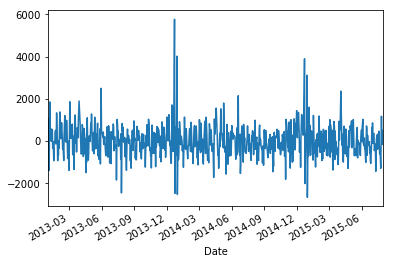

In [30]:
model.resid.plot()

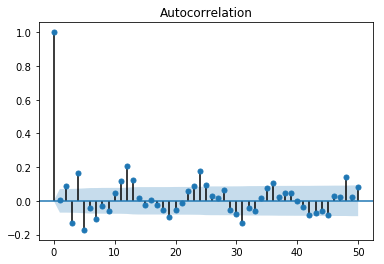

In [31]:
plot_acf(model.resid, lags=50)
plt.show()

Because of the errors, it doesn't look like an AR model is good enough. The data aren't stationary; they show a clear, repeating patter. So let's expand to an `ARMA` model by including a moving average factor.

In [32]:
model = ARMA(store1_sales_data, (1, 1)).fit()
print model.summary()

                              ARMA Model Results                              
Dep. Variable:                  Sales   No. Observations:                  781
Model:                     ARMA(1, 1)   Log Likelihood               -6267.111
Method:                       css-mle   S.D. of innovations            738.876
Date:                Tue, 11 Apr 2017   AIC                          12542.222
Time:                        20:30:55   BIC                          12560.865
Sample:                    07-31-2015   HQIC                         12549.392
                         - 01-02-2013                                         
                  coef    std err          z      P>|z|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
const        4762.5214     84.702     56.227      0.000      4596.509  4928.534
ar.L1.Sales     0.6979      0.035     20.095      0.000         0.630     0.766
ma.L1.Sales    -0.0294      0.045     -0.654    

In [53]:
type(store1_sales_data)

pandas.core.frame.DataFrame

In [34]:
from statsmodels.tsa.arima_model import ARIMA

# p = 2; q=2; d=0
model = ARIMA(store1_sales_data, (2, 0, 2)).fit()
print model.summary()

                              ARMA Model Results                              
Dep. Variable:                  Sales   No. Observations:                  781
Model:                     ARMA(2, 2)   Log Likelihood               -6243.725
Method:                       css-mle   S.D. of innovations            716.957
Date:                Tue, 11 Apr 2017   AIC                          12499.449
Time:                        20:32:20   BIC                          12527.413
Sample:                    07-31-2015   HQIC                         12510.204
                         - 01-02-2013                                         
                  coef    std err          z      P>|z|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
const        4761.2997     75.652     62.937      0.000      4613.025  4909.575
ar.L1.Sales    -0.2277      0.056     -4.064      0.000        -0.338    -0.118
ar.L2.Sales     0.4689      0.057      8.271    

In [35]:
model = ARIMA(store1_sales_data, (2, 1, 2)).fit()
print model.summary()

                             ARIMA Model Results                              
Dep. Variable:                D.Sales   No. Observations:                  780
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -6247.179
Method:                       css-mle   S.D. of innovations            725.652
Date:                Tue, 11 Apr 2017   AIC                          12506.358
Time:                        20:32:51   BIC                          12534.314
Sample:                    07-30-2015   HQIC                         12517.111
                         - 01-02-2013                                         
                    coef    std err          z      P>|z|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
const             0.5079      0.387      1.313      0.189        -0.250     1.266
ar.L1.D.Sales    -0.1820      0.050     -3.661      0.000        -0.279    -0.085
ar.L2.D.Sales     0.6469      0.035     

In [38]:
model = ARIMA(store1_sales_data, (2, 1, 0)).fit()
print model.summary()

                             ARIMA Model Results                              
Dep. Variable:                D.Sales   No. Observations:                  780
Model:                 ARIMA(2, 1, 0)   Log Likelihood               -6313.493
Method:                       css-mle   S.D. of innovations            792.554
Date:                Tue, 11 Apr 2017   AIC                          12634.985
Time:                        20:34:52   BIC                          12653.622
Sample:                    07-30-2015   HQIC                         12642.153
                         - 01-02-2013                                         
                    coef    std err          z      P>|z|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
const             0.1628     23.604      0.007      0.994       -46.100    46.426
ar.L1.D.Sales    -0.1847      0.036     -5.155      0.000        -0.255    -0.114
ar.L2.D.Sales    -0.0178      0.036     

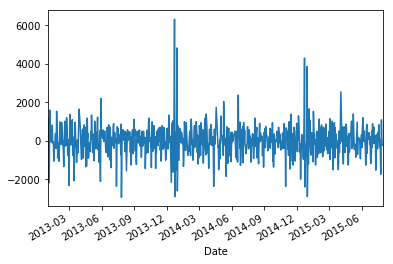

In [41]:
store1_sales_data.Sales.diff(1).autocorr(1) #-0.181

store1_sales_data.Sales.diff(1).plot()
plt.show()

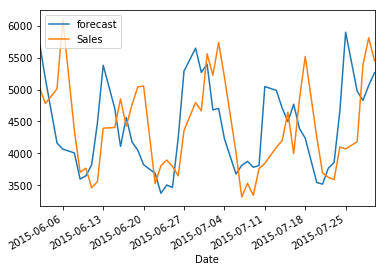

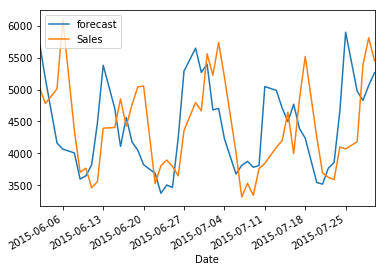

In [42]:
model.plot_predict(1, 50)

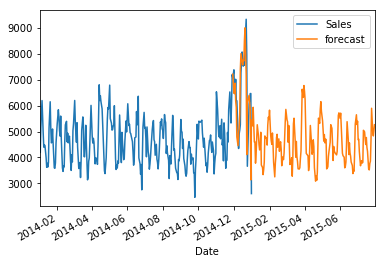

In [44]:
fig, ax = plt.subplots()
ax = store1_sales_data['2014'].plot(ax=ax)

fig = model.plot_predict(1, 200, ax=ax, plot_insample=False)

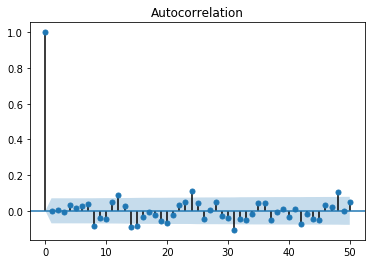

In [46]:
model = ARIMA(store1_sales_data, (7, 1, 2)).fit()
model.summary()

plot_acf(model.resid, lags=50)
plt.show()

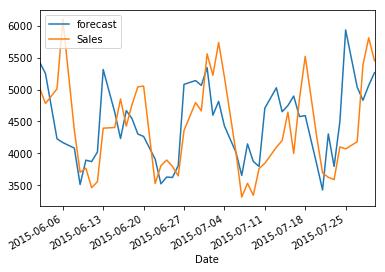

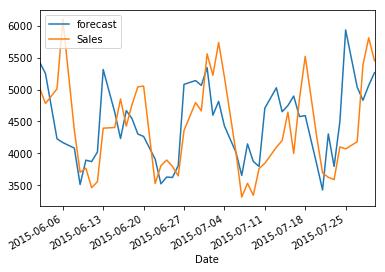

In [47]:
model.plot_predict(1, 50)

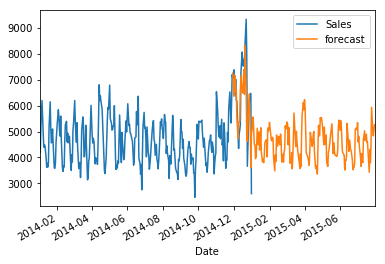

In [48]:
fig, ax = plt.subplots()
ax = store1_sales_data['2014'].plot(ax=ax)

fig = model.plot_predict(1, 200, ax=ax, plot_insample=False)

In [49]:
print model.summary()

                             ARIMA Model Results                              
Dep. Variable:                D.Sales   No. Observations:                  780
Model:                 ARIMA(7, 1, 2)   Log Likelihood               -6221.636
Method:                       css-mle   S.D. of innovations            703.783
Date:                Tue, 11 Apr 2017   AIC                          12465.272
Time:                        20:40:37   BIC                          12516.524
Sample:                    07-30-2015   HQIC                         12484.984
                         - 01-02-2013                                         
                    coef    std err          z      P>|z|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
const             0.6867      4.555      0.151      0.880        -8.241     9.614
ar.L1.D.Sales     0.8404      0.211      3.982      0.000         0.427     1.254
ar.L2.D.Sales    -0.1503      0.145     